In [ ]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median.
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default.
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Converting Pandas dataframe.
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # Finding out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encoding to int for classification.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# reformatting the time string.
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


##Switching and Verifying GPU

In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

## Enabling image classification without transfer learning.

In [ ]:
#  Load cifar-10 data and split it to training and test


from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
# Check data shape

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [ ]:
x_train

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

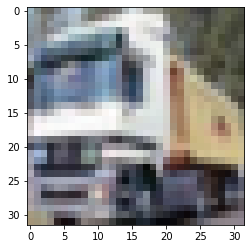

In [ ]:
# Displaying a single image for verification.
import matplotlib.pyplot as plt
plt.imshow(x_train[1])

In [ ]:
# Convert y_train from 2D to 1D    

y_train = y_train.reshape(50000)

In [ ]:
# Check y shape

y_train.shape

(50000,)

In [ ]:
# Convert y_test from 2D to 1D 
y_test = y_test.reshape(10000)

In [ ]:
y_test.shape

(10000,)

In [ ]:
# Convert class vectors to one hot format

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Convert data from int to float and normalize it

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [ ]:
# Creating the CNN and adding different layers.
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(10, 10), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(32, 32, 3)))

cnn.add(Conv2D(64, (5, 5), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=None))
cnn.add(Dropout(0.25)) 

cnn.add(Flatten())

cnn.add(Dense(128, activation='relu'))

cnn.add(Dropout(0.5))

cnn.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# Print model summary

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 32)        9632      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               663680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
# Training the dataset using earlystopping.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import time

start_time = time.time()

# 1% of dataset
cnn.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])


cnn.fit(x_train, y_train,     
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test))
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 - 17s - loss: 1.8321 - acc: 0.3260 - val_loss: 1.5587 - val_acc: 0.4353
Epoch 2/10
50000/50000 - 13s - loss: 1.5926 - acc: 0.4219 - val_loss: 1.4466 - val_acc: 0.4719
Epoch 3/10
50000/50000 - 13s - loss: 1.5054 - acc: 0.4560 - val_loss: 1.3878 - val_acc: 0.4989
Epoch 4/10
50000/50000 - 13s - loss: 1.4438 - acc: 0.4786 - val_loss: 1.4069 - val_acc: 0.4982
Epoch 5/10
50000/50000 - 13s - loss: 1.3976 - acc: 0.4991 - val_loss: 1.2874 - val_acc: 0.5371
Epoch 6/10
50000/50000 - 13s - loss: 1.3483 - acc: 0.5175 - val_loss: 1.2989 - val_acc: 0.5364
Epoch 7/10
50000/50000 - 13s - loss: 1.3121 - acc: 0.5314 - val_loss: 1.2314 - val_acc: 0.5629
Epoch 8/10
50000/50000 - 13s - loss: 1.2715 - acc: 0.5448 - val_loss: 1.2518 - val_acc: 0.5614
Epoch 9/10
50000/50000 - 13s - loss: 1.2411 - acc: 0.5565 - val_loss: 1.2065 - val_acc: 0.5798
Epoch 10/10
50000/50000 - 13s - loss: 1.2027 - acc: 0.5697 - val_loss: 1.1987 - val_acc: 0.5769

### Printing out the Precision, Recall,  F1 score, and classification reports

In [ ]:
# Calculating and presenting the results.

from sklearn import metrics

# Computing the loss and accuracy.
score = cnn.evaluate(x_test, y_test, verbose=0)
score

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

y_true = np.argmax(y_test,axis=1)
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

# Displaying the results.
score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))

f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
      
print(metrics.classification_report(y_true, pred, digits = 4))

Test loss: 1.1987350189208985
Test accuracy: 0.5769000053405762
Accuracy: 0.5769
Averaged F1: 0.5749465464084804
              precision    recall  f1-score   support

           0     0.6725    0.6140    0.6419      1000
           1     0.7663    0.6460    0.7010      1000
           2     0.5048    0.4210    0.4591      1000
           3     0.3550    0.4470    0.3958      1000
           4     0.5383    0.4290    0.4775      1000
           5     0.5419    0.4070    0.4649      1000
           6     0.5723    0.7480    0.6485      1000
           7     0.7131    0.6140    0.6599      1000
           8     0.5954    0.7490    0.6634      1000
           9     0.5896    0.6940    0.6376      1000

    accuracy                         0.5769     10000
   macro avg     0.5849    0.5769    0.5749     10000
weighted avg     0.5849    0.5769    0.5749     10000



In [ ]:
# Reloading the data to be used with transfer learning.

(x_train, y_train), (x_test, y_test) = cifar10.load_data()



print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [ ]:
# Using a pre-trained model called VGG16 to predict images.
import skimage.transform

# Assigning the training data
new_x_train = []

for image in x_train:
  newImage = skimage.transform.resize(image, (64, 64))
  new_x_train.append(newImage)

In [ ]:
# Convert training data to an array and check it's shape.
new_x_train = np.asarray(new_x_train)
new_x_train.shape

In [ ]:
# Assigning the test data
new_x_test = []

for image in x_test:
  newImage = skimage.transform.resize(image, (64, 64))
  new_x_test.append(newImage)

In [ ]:
# Convert testing data to an array and check it's shape.
new_x_test = np.asarray(new_x_test)
new_x_test.shape

In [ ]:
# Converting the y data into 1D and one-hot encoding it.
y_train_new = y_train.reshape(y_train.shape[0], 1)
y_test_new = y_test.reshape(y_test.shape[0], 1)

print(y_train_new.shape)
print(y_test_new.shape)

(50000, 1)
(10000, 1)


In [ ]:
# Checking the shape of the y train and test data.
import tensorflow as tf

y_train_cat = tf.keras.utils.to_categorical(y_train_new, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test_new, 10)
print(y_train_cat.shape)
print(y_test_cat.shape)

(50000, 10)
(10000, 10)


In [ ]:
# Loading the pre-trained VGG16 model and displaying the layers.
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = Sequential()

# Adding in the layers from the VGG16 model
for layer in vgg_model.layers:
  model.add(layer)

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_______________________________________________________

In [ ]:
# Freezing the weights in each layer on the new model.
for layer in model.layers:
  layer.trainable = False

In [ ]:
# Adding an output layer to the model.
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [ ]:
# Fitting and compiling the model utilizing earlystopping.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time 

start_time = time.time()

# 1% of dataset
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

model.fit(x_train, y_train_cat,     
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test_cat))
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 - 32s - loss: 5.2188 - acc: 0.4642 - val_loss: 2.5154 - val_acc: 0.5129
Epoch 2/10
50000/50000 - 32s - loss: 2.0734 - acc: 0.5337 - val_loss: 2.0400 - val_acc: 0.5071
Epoch 3/10
50000/50000 - 32s - loss: 1.9111 - acc: 0.5327 - val_loss: 1.9737 - val_acc: 0.5211
Epoch 4/10
50000/50000 - 32s - loss: 1.8937 - acc: 0.5314 - val_loss: 1.9224 - val_acc: 0.5352
Epoch 5/10
50000/50000 - 32s - loss: 1.8751 - acc: 0.5330 - val_loss: 1.9307 - val_acc: 0.5191
Epoch 6/10
50000/50000 - 32s - loss: 1.9183 - acc: 0.5284 - val_loss: 1.9730 - val_acc: 0.5243
Epoch 7/10
50000/50000 - 32s - loss: 1.8741 - acc: 0.5311 - val_loss: 1.8865 - val_acc: 0.5335
Epoch 8/10
50000/50000 - 32s - loss: 1.8785 - acc: 0.5323 - val_loss: 1.8674 - val_acc: 0.5303
Epoch 9/10
50000/50000 - 32s - loss: 1.8869 - acc: 0.5285 - val_loss: 2.0960 - val_acc: 0.5161
Epoch 10/10
50000/50000 - 32s - loss: 1.8949 - acc: 0.5314 - val_loss: 1.9413 - val_acc: 0.5432

In [ ]:
# Printing out the metrics
from sklearn import metrics

# Computing the loss and accuracy of the model.
score = model.evaluate(x_test, y_test_cat, verbose=0)
score
print('P1')
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

y_true = np.argmax(y_test_cat,axis=1)
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

# Displaying classification report.
score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))

f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))
           
print(metrics.classification_report(y_true, pred, digits = 4))

P1
Test loss: 1.941266738319397
Test accuracy: 0.5432000160217285
Accuracy: 0.4034
Averaged F1: 0.3624431073032142
              precision    recall  f1-score   support

           0     0.3006    0.8320    0.4416      1000
           1     0.3366    0.8580    0.4835      1000
           2     0.5259    0.2030    0.2929      1000
           3     0.4521    0.0850    0.1431      1000
           4     0.6207    0.0360    0.0681      1000
           5     0.4850    0.4190    0.4496      1000
           6     0.7590    0.2520    0.3784      1000
           7     0.4685    0.5720    0.5151      1000
           8     0.6451    0.3090    0.4178      1000
           9     0.4052    0.4680    0.4343      1000

    accuracy                         0.4034     10000
   macro avg     0.4999    0.4034    0.3624     10000
weighted avg     0.4999    0.4034    0.3624     10000



Image (#1): Which is digit '[9]'


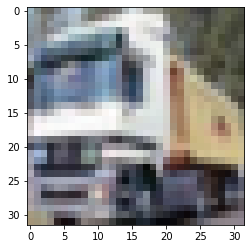

In [ ]:
# Displaying an example image and it's true label to refer to.
print("Image (#{}): Which is digit '{}'".format(1,y_train[1]))
plt.imshow(x_train[1])

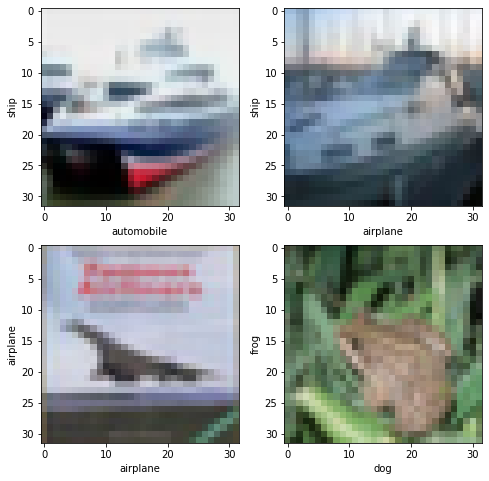

In [ ]:
# Displaying four images with the model predictions to compare. 
import numpy as np
import matplotlib.pyplot as plt
import random

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    true_object = cifar_classes[y_true.item(i)]
    pred_object = cifar_classes[pred.item(i)]
    plt.ylabel(true_object)
    plt.xlabel(pred_object)

    plt.imshow(x_test[i])
    
plt.show()